In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
import seaborn as sns

# Download required NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [2]:
def preprocess_text(text):
    # Convert to lowercase
    text = str(text).lower()

    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    # Remove user mentions
    text = re.sub(r'@\w+', '', text)

    # Remove hashtags
    text = re.sub(r'#\w+', '', text)

    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)

    # Remove numbers
    text = re.sub(r'\d+', '', text)

    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text

def create_features(df):
    # Text length
    df['text_length'] = df['text'].str.len()

    # Word count
    df['word_count'] = df['text'].str.split().str.len()

    # Average word length
    df['avg_word_length'] = df['text'].apply(lambda x: np.mean([len(word) for word in str(x).split()]))

    # Hashtag count
    df['hashtag_count'] = df['text'].str.count('#')

    # Mention count
    df['mention_count'] = df['text'].str.count('@')

    # URL count
    df['url_count'] = df['text'].str.count('http')

    return df

# Load and preprocess data
df = pd.read_csv('bdCalling IT Ltd..csv')

# Clean text
df['cleaned_text'] = df['text'].apply(preprocess_text)

# Create additional features
df = create_features(df)

# Encode sentiment labels
le = LabelEncoder()
df['sentiment_encoded'] = le.fit_transform(df['Sentiment'])

In [3]:
# Tokenization and padding
MAX_WORDS = 10000
MAX_LENGTH = 100

tokenizer = Tokenizer(num_words=MAX_WORDS)
tokenizer.fit_on_texts(df['cleaned_text'])
sequences = tokenizer.texts_to_sequences(df['cleaned_text'])
padded_sequences = pad_sequences(sequences, maxlen=MAX_LENGTH)

# Get additional features
additional_features = df[['text_length', 'word_count', 'avg_word_length',
                         'hashtag_count', 'mention_count', 'url_count']].values

# Split the data
X_text = padded_sequences
X_additional = additional_features
y = df['sentiment_encoded']

X_text_train, X_text_test, X_add_train, X_add_test, y_train, y_test = train_test_split(
    X_text, X_additional, y, test_size=0.2, random_state=42
)

In [4]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Concatenate, Dropout
from tensorflow.keras.optimizers import Adam

# Text input branch
text_input = Input(shape=(MAX_LENGTH,))
embedding_layer = Embedding(MAX_WORDS, 100)(text_input)
lstm_layer = LSTM(64)(embedding_layer)

# Additional features branch
additional_input = Input(shape=(6,))
additional_dense = Dense(32, activation='relu')(additional_input)

# Merge branches
merged = Concatenate()([lstm_layer, additional_dense])
dense1 = Dense(64, activation='relu')(merged)
dropout = Dropout(0.3)(dense1)
output = Dense(3, activation='softmax')(dropout)

# Create and compile model
model = Model(inputs=[text_input, additional_input], outputs=output)
model.compile(optimizer=Adam(learning_rate=0.001),
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

# Model summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 100)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 100, 100)       │      1,000,000 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_1             │ (None, 6)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm (LSTM)               │ (None, 64)             │         42,240 │ embedding[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 32)             │            224 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 96)             │              0 │ lstm[0][0],            │
│                           │                        │                │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 64)             │          6,208 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 64)             │              0 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 3)              │            195 │ dropout[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 1,048,867 (4.00 MB)

 Trainable params: 1,048,867 (4.00 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
402/402 ━━━━━━━━━━━━━━━━━━━━ 38s 83ms/step - accuracy: 0.4861 - loss: 2.7914 - val_accuracy: 0.7761 - val_loss: 0.5960
Epoch 2/10
402/402 ━━━━━━━━━━━━━━━━━━━━ 39s 79ms/step - accuracy: 0.8264 - loss: 0.4935 - val_accuracy: 0.8605 - val_loss: 0.4418
Epoch 3/10
402/402 ━━━━━━━━━━━━━━━━━━━━ 42s 82ms/step - accuracy: 0.9169 - loss: 0.2712 - val_accuracy: 0.9010 - val_loss: 0.3376
Epoch 4/10
402/402 ━━━━━━━━━━━━━━━━━━━━ 33s 82ms/step - accuracy: 0.9607 - loss: 0.1430 - val_accuracy: 0.8991 - val_loss: 0.3924
Epoch 5/10
402/402 ━━━━━━━━━━━━━━━━━━━━ 33s 83ms/step - accuracy: 0.9743 - loss: 0.0922 - val_accuracy: 0.9103 - val_loss: 0.3743
Epoch 6/10
402/402 ━━━━━━━━━━━━━━━━━━━━ 41s 82ms/step - accuracy: 0.9816 - loss: 0.0731 - val_accuracy: 0.8997 - val_loss: 0.3813
Epoch 7/10
402/402 ━━━━━━━━━━━━━━━━━━━━ 40s 81ms/step - accuracy: 0.9834 - loss: 0.0652 - val_accuracy: 0.9041 - val_loss: 0.4547
Epoch 8/10
402/402 ━━━━━━━━━━━━━━━━━━━━ 41s 81ms/step - accuracy: 0.9857 - loss: 0.0600 - 

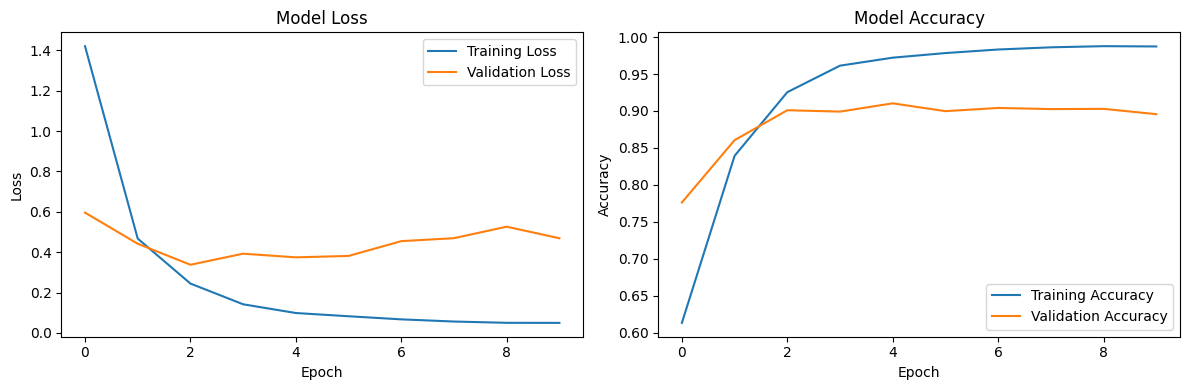

In [5]:
# Train the model
history = model.fit(
    [X_text_train, X_add_train],
    y_train,
    validation_split=0.2,
    epochs=10,
    batch_size=32
)

# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

126/126 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step
Classification Report:
              precision    recall  f1-score   support

    Negative       0.76      0.86      0.81       733
     Neutral       0.94      0.93      0.93      1345
    Positive       0.94      0.90      0.92      1936

    accuracy                           0.90      4014
   macro avg       0.88      0.90      0.89      4014
weighted avg       0.91      0.90      0.90      4014



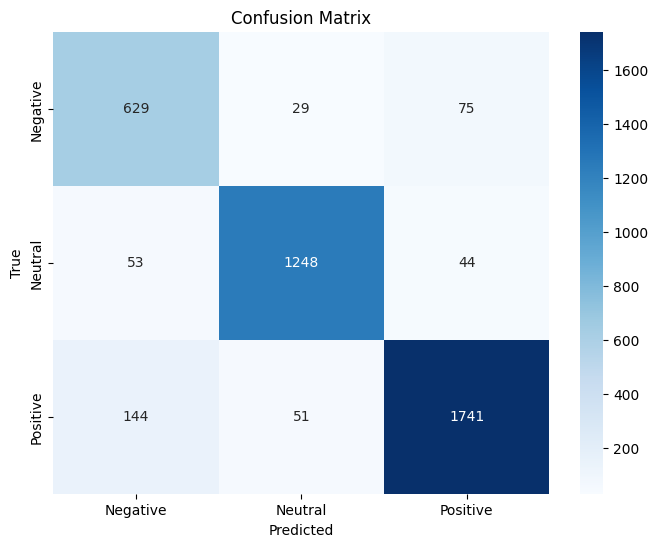

In [7]:
# Make predictions
y_pred = model.predict([X_text_test, X_add_test])
y_pred_classes = np.argmax(y_pred, axis=1)

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred_classes,
                          target_names=le.classes_))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

<Figure size 1200x600 with 0 Axes>

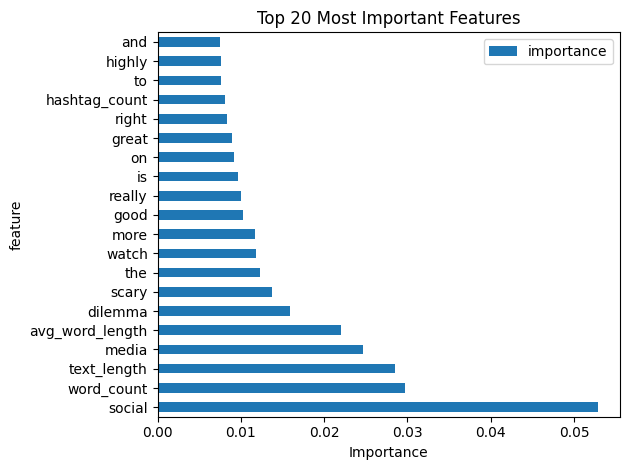

In [13]:
# Analyze feature importance using a simpler model
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier

# Create TF-IDF features
tfidf = TfidfVectorizer(max_features=1000)
X_text_tfidf = tfidf.fit_transform(df['cleaned_text'])

# Combine with additional features
X_combined = np.hstack((X_text_tfidf.toarray(), X_additional))

# Train Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_combined, y)

# Get feature importance
feature_importance = pd.DataFrame({
    'feature': list(tfidf.get_feature_names_out()) + ['text_length', 'word_count',
                                                      'avg_word_length', 'hashtag_count',
                                                      'mention_count', 'url_count'],
    'importance': rf_model.feature_importances_
})

# Plot top 20 important features
plt.figure(figsize=(12, 6))
feature_importance.nlargest(20, 'importance').plot(
    kind='barh', x='feature', y='importance'
)
plt.title('Top 20 Most Important Features')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()